# ProxyStore with FaaS for RDMA Stores

In this experiment, we use the `InstrasiteStore` to measure intra-site communication via advanced networking technologies (i.e., RDMA).
This experiment is a modification of `0-proxystore-with-faas`.

## Instructions

### Setup

Setup needs to be performed on all sites that will be used.

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a FuncX endpoint. Note that the endpoint configuration will need to be changed customized for the system, allocations, etc.
   ```bash
   $ funcx-endpoint configure psbench
   $ funcx-endpoint start psbench
   ```
   Endpoint config reference: https://funcx.readthedocs.io/en/latest/endpoints.html
3. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench --server {SIGNALING SERVER}
   $ proxystore-endpoint start psbench &> /dev/null &
   ```
   Note: endpoint logs will still be written to ~/.proxystore

### Run

```bash
$ python -m psbench.benchmarks.funcx_tasks \
    --funcx-endpoint {UUID} \  # UUID returned by funcx-endpoint start
    --task-repeat 5 \
    --task-sleep 0.0 \
    --input-sizes 100 1000 10000 \
    --output-sizes 0 \
    --ps-backend ENDPOINT --ps-endpoints {UUID} {UUID} \ # UUIDs for all ProxyStore endpoints
    --csv-file {OUTPUT-CSV-FILE}
```

### Notes

- All experiments done with Python 3.9
- proxystore-benchmark commit hash used: `bf643cd2dee85e243f92c824cd701ee02ac8ace5`
- When a job is needed for a worker, its best to run a small benchmark to allocate nodes then run the benchmark for real.
  ```

In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy
import seaborn

# to change default colormap
plt.rcParams["image.cmap"] = "tab10"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [2]:
BACKEND_COLUMN = 'proxystore_backend'
INPUT_SIZE_COLUMN = 'input_size_bytes'
TOTAL_TIME_COLUMN = 'total_time_ms'
SLEEP_COLUMN = 'task_sleep_seconds'

def load(filepath: str) -> pandas.DataFrame:
    df = pandas.read_csv(filepath)
    df[BACKEND_COLUMN] = df[BACKEND_COLUMN].fillna('FuncX')
    return df

In [3]:
def get_backends(data: pandas.DataFrame):
    return data[BACKEND_COLUMN].unique()

def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_input_sizes(data: pandas.DataFrame):
    return list(data[INPUT_SIZE_COLUMN].unique())

def get_avg_total_time(data: pandas.DataFrame) -> float:
    """Drops min/max and takes average of remaining times."""
    times = list(data[TOTAL_TIME_COLUMN])
    if len(times) < 3:
        raise ValueError('Cannot drop min/max value when row count < 3')
    times.remove(min(times))
    times.remove(max(times))
    return sum(times) / len(times)

def extract_avg_times(data: pandas.DataFrame):
    # Input dataframe should just contain one backend type
    assert len(get_backends(data)) == 1
    input_sizes = get_input_sizes(data)
    input_sizes
    avg_times = [
        get_avg_total_time(rows_matching_column_value(data, INPUT_SIZE_COLUMN, input_size)) for input_size in input_sizes
    ]
    # Convert to seconds
    avg_times = [x / 1000 for x in avg_times]
    return {'sizes': input_sizes, 'times': avg_times}

def extract(data: pandas.DataFrame):
    result = {}
    for backend in get_backends(data):
        subset = rows_matching_column_value(data, BACKEND_COLUMN, backend)
        result[backend] = extract_avg_times(subset)
    return result

# Intrasite experiments

Notes:
- Compared IntrasiteStore websockets, mochi, and ucx implementations with FileStore and Redis
- All experiments used 3.9.12 with the exception of UCX-py which required Python 3.7 (installed as per Read-the-docs instructions)

In [4]:
pandas.set_option('display.max_rows', 500)
intrasite_polaris_noop_data = load('data/4-rdma-performance/intrasite_noop.csv')
extracted_intrasite = extract(intrasite_polaris_noop_data)

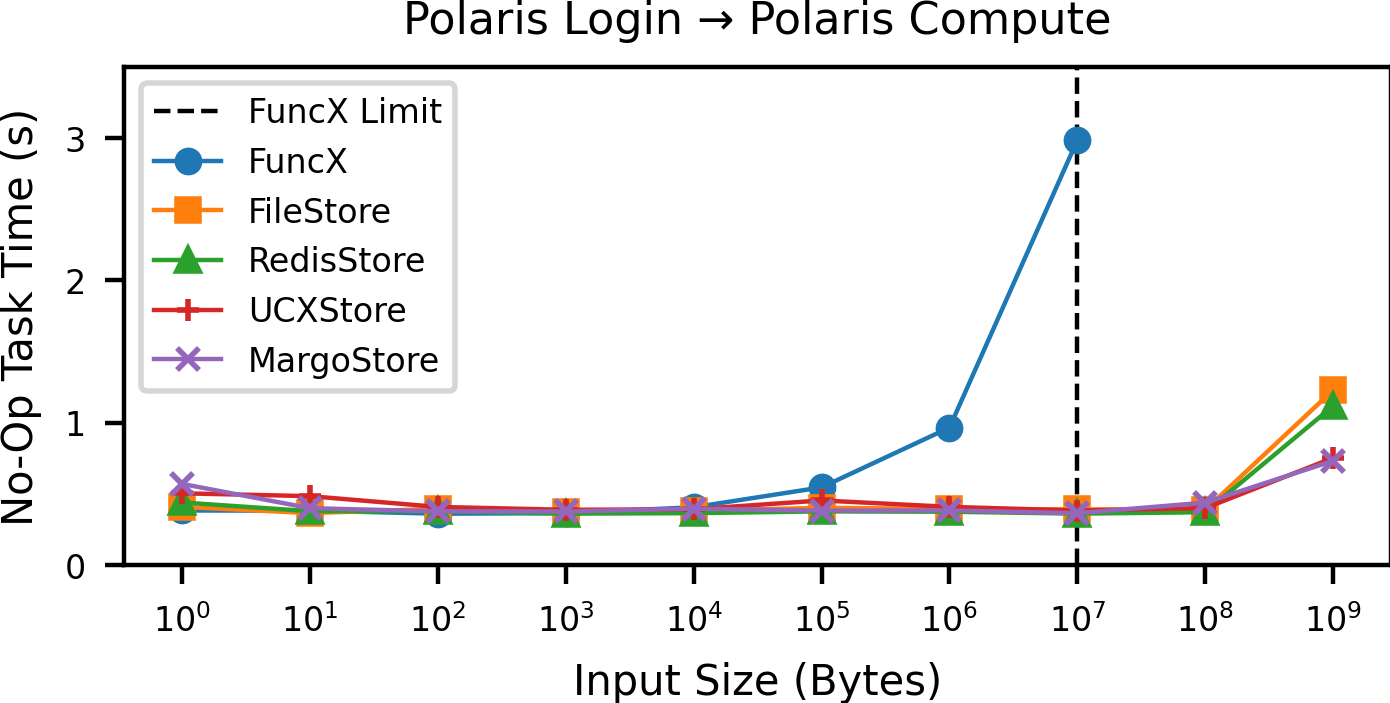

In [11]:
i_backends = ['FuncX', 'FileStore', 'RedisStore', 'ucx', 'margo']

fig, ax = plt.subplots(1, 1, sharex=True)

cmap = plt.get_cmap()
colors = {backend: cmap(i) for i, backend in enumerate(i_backends)}
markers_ = {backend: ('o', 's', '^', '+', 'x', 'P')[i] for i, backend in enumerate(i_backends)}
legend_handles = {}  # backend (str): axs handle

ax.axvline(1e7, color='black', linestyle='--', label='FuncX Limit')

data = extracted_intrasite
for backend in i_backends:
    if backend in data:
        xy = [(x, y) for x, y in zip(data[backend]['sizes'], data[backend]['times']) if 0 < x < 1e10]
        x, y  = zip(*xy)
        ax.plot(x, y, marker=markers_[backend], label=backend, color=colors[backend])

ax.set_xscale('log')
ax.set_xticks([10 ** x for x in range(0, 10)])

handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label == 'websockets':
        label = f'WebSocketStore'
    elif label == 'ucx':
        label = 'UCXStore'
    elif label == 'margo':
        label = 'MargoStore'
    if label not in legend_handles:
        legend_handles[label] = handle

# Annotation for the WebSocketStore that's super high
# ax.annotate(
#     '$35.63$',
#     xy=(0.95, 0.98),
#     xycoords='axes fraction',
#     xytext=(0.95, 0.7),
#     textcoords='axes fraction',
#     arrowprops=dict(facecolor='black', arrowstyle='->'),
#     horizontalalignment='center',
#     fontsize=6,
# )

ax.set_xlabel('Input Size (Bytes)', fontsize=7.5)
ax.set_ylabel('No-Op Task Time (s)', fontsize=7.5)
ax.set_title('Polaris Login → Polaris Compute')

# Reorder legend
ax.legend(legend_handles.values(), legend_handles.keys(), loc='upper left')

# Restrict y axis range
ax.set_ylim([0, 3.5])

# Restrict y labels to integers
ax.get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))

fig.tight_layout() #h_pad=1, w_pad=0)

fig.set_size_inches(3.5, 1.5)
plt.savefig('figures/funcx-roundtrip-task-times-intrasite.png', pad_inches=0.05)